# Learning and controlling a room's temperature
### By Farzad Vatandoust
### Email: vatandoustf@gamil.com
### GitHub: https://github.com/FarzadVatandoust

Table of content


# Introduction

The goal of this projects is to exmine different ways to control a temperature of a room with a model predictive controller. This control method  rquires a surrogate model of the plant to predict the plant behavior in a near future which is typically called control horizon. The controller optimize the controls input for the horizon and use the first prediciotn as the actual control input. Later, after aqcuiring the feedback from actual plant the controller shift its horizon forward and does the same process again. The advantages of this method are that the controller adjust the it's input based on the event in the future and the user can apply constraints on the controller inputs during the process. the figure blow represent a detailed schematic of the model predictive control.


![Model Predictive controll](./pic/pic1.png "Text to show on mouseover")

As you may unterstood yourself one of the most crucial part of MPC is the plant surrogate model. There are several methods for create this twin model of the plant from simple method like liniear approximation of the plant to state-of-the-art method like deep learning. The goal of this project is identify the a model for a temperature of the room from temporal data with different method and incorporate them in developing an MPC for controlling the room temperature.

 So, let's start analyzing our data.

## 1: Loading and analyzing the data

First we need to import the required libraries for data analysis and plotting 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv')
values = dataset.values
print(dataset.head())

                    time  room_temp  supply_temp  htg_setpoint  \
0  2021-04-26T09:37:00.0       72.3         59.3          68.5   
1  2021-04-26T09:38:00.0       72.2         58.8          68.5   
2  2021-04-26T09:39:00.0       72.2         58.5          68.5   
3  2021-04-26T09:40:00.0       72.1         58.2          68.5   
4  2021-04-26T09:41:00.0       71.9         58.1          68.5   

   airflow_current  htg_mode  
0              416     False  
1              413     False  
2              419     False  
3              410     False  
4              404     False  


We can see that our data is consited of seven columns which every rows represent different time. Here the room temperature is the state of our system and the two control variable are supply temperature and airflow current of the heater. The other parameters such heater setpoint and heater mode are not useful for create a surrogate model of our system so we will not use them anymore.

In [16]:
# drop unwanted data
del dataset['htg_setpoint']
del dataset['htg_mode']
print(dataset.head())

                    time  room_temp  supply_temp  airflow_current
0  2021-04-26T09:37:00.0       72.3         59.3              416
1  2021-04-26T09:38:00.0       72.2         58.8              413
2  2021-04-26T09:39:00.0       72.2         58.5              419
3  2021-04-26T09:40:00.0       72.1         58.2              410
4  2021-04-26T09:41:00.0       71.9         58.1              404


Lets plot our important data to get a better understanding of it.

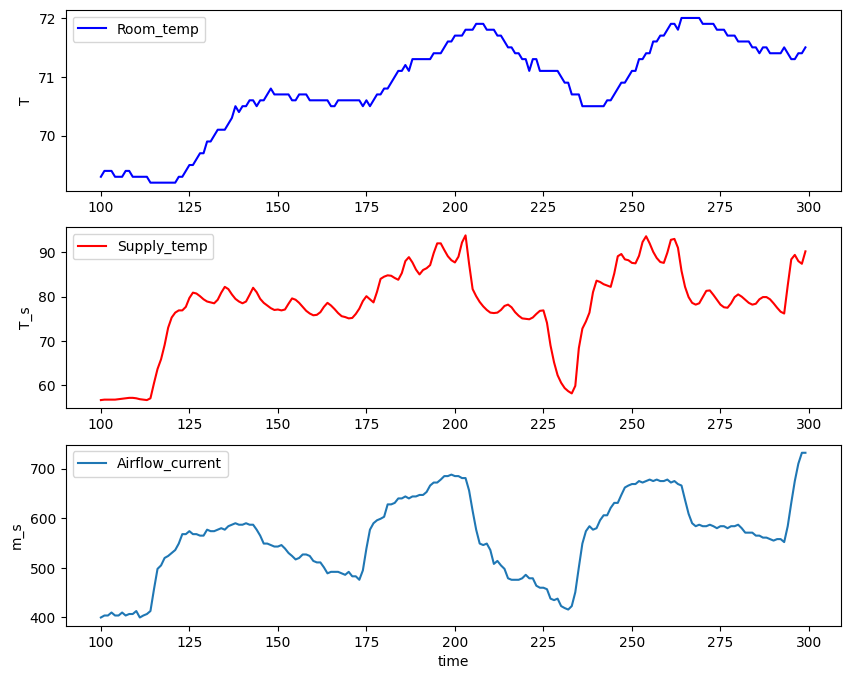

In [17]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

The data is represented in three subpplot showing the room-temperature, supply-temperature, and airflow-current. These plots confirm our intuation about a room temperature system since there is direct relationship between the supply_temperature and the airflow_current with the room temperature. However, there is a delay between these parameter and the state of the system which is easliy justifiable.

### Train/Test/Validation split (Global)

here we devide our data into different groups of train, test, and validation and we will use this partitioning for all of our study. Here, since our data is temporal we could not use the conventional random selection. So, we used the method suggestetd in [toardsdatascience.com](https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37).

In [18]:
train_nu = int(np.floor(0.7 * len(dataset)))
test_nu = int(np.floor(0.15 * len(dataset)))
val_nu = len(dataset) - train_nu - test_nu

# 2: Identifying the system's surrogate model


For identtification method for this project we are two methods. The first one is to use the differential equation model of the room temperature system and approximate its constant by fiiting our model to the data. The second method is using the deep learning techniques like recurrent neural network method for learning the data.

## 2.1: differential equation model

Our differential equation model is as follows,

$C\dot{T}  = K(T_a(t) - T(t))+\dot{m}_s(t) c_a (T_s(t)-T(t))+d(t)$

System output:
- $T(t)$: the room temperature at time $t$

Control parameters:
- $\dot{m}_s$: mass flow rate
- $T_s(t)$: temperature of the supply air

System parameters:
- $K$: the heat transfer coefficient
- $T_a$: the temperature outside the room at time $t$ (Constant)
- $c_a$: the specific heat capacity of air
- $d(t)$:the unknown disturbance into the room at time $t$ (Constant)
- $C$: the heat capacity of the room air,

For this system identification we used different optimization methods and here we give brief summary of their performance. Later, we devlope the succesfull methods and see their results.


- gekko IPOPT : https://apmonitor.com/do/index.php/Main/TCLabA (Too Slow)
- solve_ivp + scipy: 
- julia: 
- CasADi(IPOPT): it is not developed yet


Lets import the necessary libraries

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy import optimize
import scipy
import casadi as ca

Train/Test/Validation split

In [72]:
train_data = dataset[0:train_nu]
test_data = dataset[train_nu:train_nu + test_nu]
test_data = test_data.reset_index()
val_data= dataset[train_nu + test_nu: ]
val_data = val_data.reset_index()

### 2.1.1: solve_ivp + scipy

We define a function for room temperature model

In [152]:
def model(t, T, p, Ts, Ms):
    dTdt = (p[0] * (p[1] - T) + Ms * p[2] * (Ts - T) + p[3]) / p[4]
    return dTdt

Then, we define a function for solving an initial value problem and ploting the difference between the ordinary differential equation model and actual data

In [153]:
def display(p, model, dataset):


    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(dataset), 1)
    T = np.zeros(len(dataset))
    T[0] = T0
    z0 = T0
    for i in range (1, len(dataset)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]

    # plot results
    fig = plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    plt.plot(t, T)
    plt.plot(t, dataset['room_temp'][t])
    plt.legend(["Model","Real Data"])
    plt.xlabel('time')
    plt.ylabel('T(t)')

    plt.subplot(1,2,2)
    plt.scatter(T/np.max(T), dataset['room_temp'][t]/np.max(dataset['room_temp'][t]))
    lolim = min(np.min(T/np.max(T)),
    np.min(dataset['room_temp'][t]/np.max(dataset['room_temp'][t])))
    uplim = 1
    plt.plot([lolim, uplim ], [lolim, uplim ], "k")
    plt.xlim(lolim , uplim )
    plt.ylim(lolim, uplim)

    plt.show()

Later, we create a function for calculation root mean squared error ($RMSE$) and $R^2$ score.

In [161]:
def RMSE_R2(p, model, dataset):
    Ts = np.array(dataset['supply_temp'])
    Ms = np.array(dataset['airflow_current'])
    T0 = dataset['room_temp'][0]
    t = np.arange(0, len(test_data), 1)
    T = np.zeros(len(test_data))
    T[0] = T0
    z0 = T0
    for i in range (1, len(test_data)):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(dataset['room_temp'][:len(test_data)])
    predicted = T
    rmse = sum((actual-predicted)**2)/len(test_data)
    corr_matrix = np.corrcoef(actual, predicted)
    corr = corr_matrix[0,1]
    r_sq = corr**2

    return rmse, r_sq

Displaying the model performance on testing set before optimization

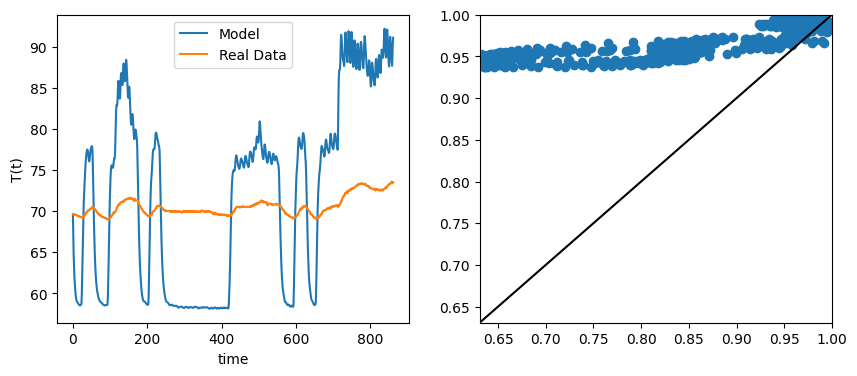

RMSE=114.81479514912897, Rsq=0.6567559364956972


In [162]:
p = [100, 70, 2, 10, 3000]
display(p, model, test_data)
rmse, rsq = RMSE_R2(p, model, test_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Displaying the model performance on validation set before optimization

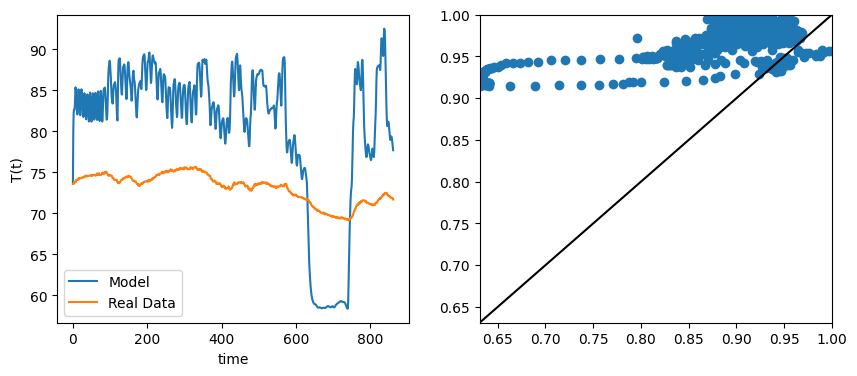

RMSE=113.60338653918957, Rsq=0.5762879456353054


In [163]:
p = [100, 70, 2, 10, 3000]
display(p, model, val_data)
rmse, rsq = RMSE_R2(p, model, val_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Next, we define an objective function which calculate the root mean squared error between the model and actual data in the training set

In [164]:
def objective_func(p):
    Ts = np.array(train_data['supply_temp'])
    Ms = np.array(train_data['airflow_current'])
    T0 = train_data['room_temp'][0]
    t = np.arange(0, train_nu, 1)
    T = np.zeros(train_nu)
    T[0] = T0
    z0 = T0
    for i in range (1, train_nu):
        ts = (t[i-1], t[i])
        # solve ODE
        z = solve_ivp(model, t_span=ts, y0=[z0],
                    args=(p, Ts[i-1], Ms[i-1]))
        T[i] = z.y[0][-1]
        z0 = z.y[0][-1]
           
    actual = np.array(train_data['room_temp'][:train_nu])
    predicted = T
    mse = np.sqrt(sum((actual-predicted)**2)/train_nu)
    return mse

Finally we use SLSQP optimization for finding the the constants in our differential equation. This method rquires the lower- and upper- bound for optimization variable. So, we used the feasible range of each of the variables for their bound. The $d(t)$ was defined as air disturbance in the systems and since we are assiginng a constant value to it is not intuitive to give it the wide range.

In [170]:
initial_condition = ([100, 70, 2, 10, 2000])
bnds = ((0, 300),
        (30, 100),
        (0.001, 10),
        (-100, 100),
        (1000, 10000))
Nfeval = 0
def mycallback(x):
  global Nfeval
  cost = objective_func(x)
  Nfeval += 1
  print ('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}   {5: 3.6f}  {6: 3.6f}'.format(Nfeval, x[0], x[1], x[2], x[3], x[4], cost))

print('{0:4s}        {1:9s}     {2:9s}   {3:9s}   {4:9s}     {5:9s}   {6:9s}'.format('Iter', 'K', 'Ta', 'ca', ' d', 'C', 'Cost')) 
res = scipy.optimize.minimize(objective_func, initial_condition, method='SLSQP', bounds=bnds, tol=1e-6, callback=mycallback)

Iter        K             Ta          ca           d            C           Cost     
   1    100.010027    69.984692    1.401746    9.999846    2000.000097   11.410973


d:\Control\01-Learning and controlling a room's temperature\MPC\.venvMPC\lib\site-packages\scipy\optimize\_optimize.py:353: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


   2    100.036398    69.939567    0.001000    9.999394    2000.000355   2.130595
   3    100.023415    69.971344    1.382942    9.999712    2000.000228   11.389061
   4    100.046744    70.109330    0.030632    10.001091    2000.000491   0.814699
   5    100.051287    70.820641    0.001000    10.008201    2000.000842   1.622634
   6    100.046549    70.540232    0.021966    10.005398    2000.000716   0.655452
   7    100.044246    70.591241    0.022226    10.005907    2000.000847   0.653690
   8    100.042486    70.590230    0.022088    10.005897    2000.000935   0.653625
   9    100.040509    70.588552    0.022108    10.005880    2000.001033   0.653620
  10    100.032679    70.586577    0.022135    10.005860    2000.001424   0.653607
  11    99.997109    70.581997    0.022193    10.005813    2000.003198   0.653558
  12    99.902958    70.575288    0.022268    10.005740    2000.007898   0.653445
  13    99.626557    70.563499    0.022376    10.005608    2000.021697   0.653136
  14    

Save the optimization result

In [172]:
pd.DataFrame(res.x).to_csv("SLSQP_opt_param.csv", header=None, index=None)

Display the performance of the optimized model on the test set

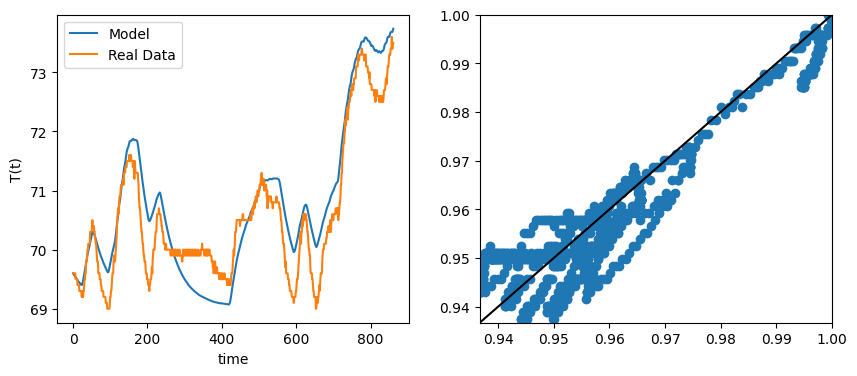

RMSE=0.27022427083995404, Rsq=0.8680754760059595


In [173]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display(p, model, test_data)
rmse, rsq = RMSE_R2(p, model, test_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Display the performance of the optimized model on the validation set

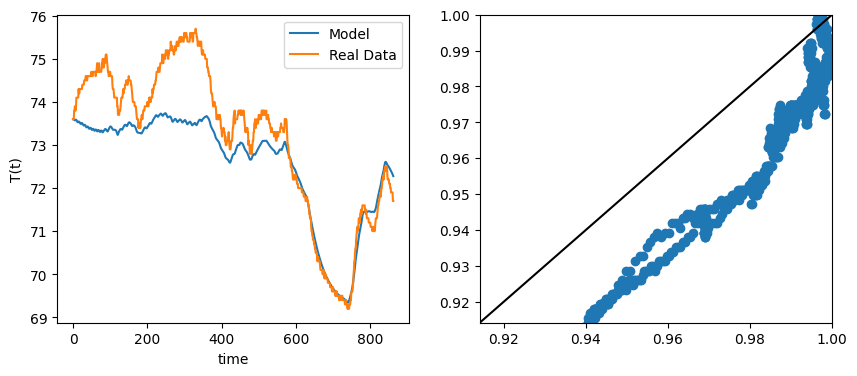

RMSE=0.7952073849198029, Rsq=0.9223736968232853


In [174]:
p = np.array(pd.read_csv('SLSQP_opt_param.csv', header=None)[0])
display(p, model, val_data)
rmse, rsq = RMSE_R2(p, model, val_data)
print("RMSE="+str(rmse)+", Rsq="+str(rsq))

Finally, we compare all the developed method of optimization

In [177]:
# Julia results
p = np.array([ 188.99, 63.23, 0.051, 1377.81, 9755.25])
j_rmse, j_rsq = RMSE_R2(p, model, test_data)

p = np.array([62.62, 70.30, 0.017, 10.00, 3001.24])
P_rmse, P_rsq = RMSE_R2(p, model, test_data)

print("Julia result :" + "RMSE=" + str(j_rmse) + "," + " R_sq=" + str(j_rsq))
print("Python result :" + "RMSE=" + str(P_rmse) + "," + " R_sq=" + str(P_rsq))

Julia result :RMSE=0.27974900111819634, R_sq=0.861966830424802
Python result :RMSE=0.26797321686075337, R_sq=0.8679569522807724


## 2.2: Learn  a Neural Network Model

Neural networks are one of the most prominent techniques in identifying the relation between data. There are several structure for neural network among which the recurrent neural network are the most suitable for temporal data. Long short-term memory network is a special kind of neural network that is developed for handeling large sequences of data since it does not suffer from vanishing gradinet. In this project we developed the LSTM neural network in both TensorFlow and Pytorch to investigate their compatibility of our optimizer in the MPC section.



### 2.2.1: LSTM via tensorflow
In the process of developing this neural network we used several useful resources as follows:
- [Recurrent Neural Networks (RNN) by sentdex](https://www.youtube.com/watch?v=BSpXCRTOLJA&list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN&index=7)
- [Multivariate Time Series Forecasting with LSTMs in Keras](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
- [How to Convert a Time Series to a Supervised Learning Problem in Python](https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)

First, we import the necessary libraries for developing neural network

In [187]:
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Then, we load our data to the environment

In [188]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


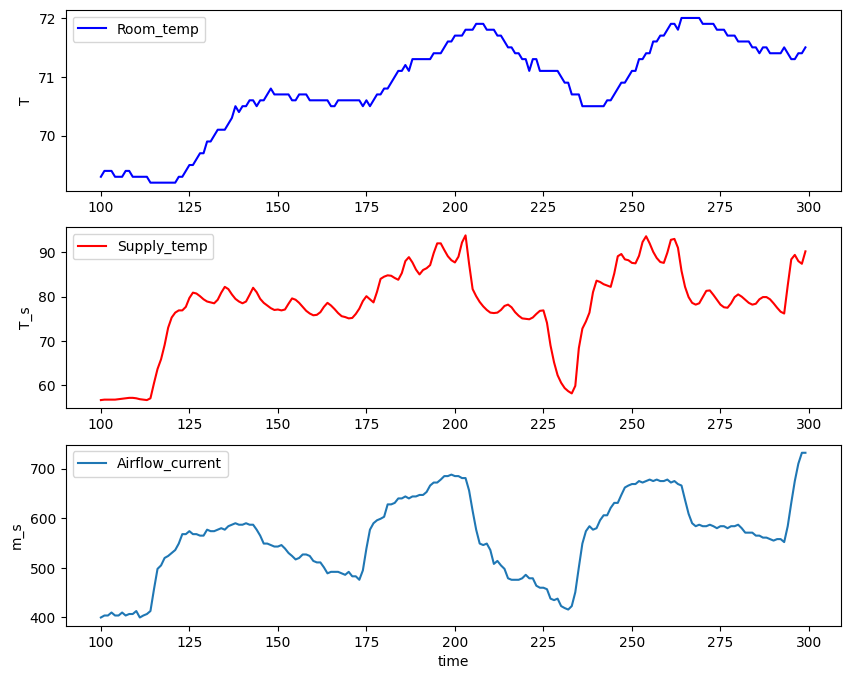

In [189]:
# plot the train data
start = 100
finish = 300
idx = np.arange(start, finish, 1)
fig = plt.figure(figsize=(10, 8))
plt.subplot(3,1,1)
plt.plot(idx, dataset['room_temp'][start:finish], 'b')
plt.ylabel('T')
plt.legend(["Room_temp"])

plt.subplot(3,1,2)
plt.plot(idx, dataset['supply_temp'][start:finish], 'r')
plt.ylabel('T_s')
plt.legend(["Supply_temp"])

plt.subplot(3,1,3)
plt.plot(idx, dataset['airflow_current'][start:finish])
plt.ylabel('m_s')
plt.legend(["Airflow_current"])

plt.xlabel('time')

plt.show()

Here, we define a function that changes the shape of our data and makes it compatible for supervised learning

In [193]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

We normalize the data and use the function to change our data

In [194]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


As you can see the data is changed and is in the form of $R$

In [195]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(4022, 1, 3) (4022,) (862, 1, 3) (862,)


Epoch 1/100
32/32 - 5s - loss: 0.1734 - val_loss: 0.0345 - 5s/epoch - 154ms/step
Epoch 2/100
32/32 - 0s - loss: 0.0608 - val_loss: 0.0074 - 195ms/epoch - 6ms/step
Epoch 3/100
32/32 - 0s - loss: 0.0176 - val_loss: 0.0134 - 141ms/epoch - 4ms/step
Epoch 4/100
32/32 - 0s - loss: 0.0122 - val_loss: 0.0125 - 143ms/epoch - 4ms/step
Epoch 5/100
32/32 - 0s - loss: 0.0114 - val_loss: 0.0109 - 148ms/epoch - 5ms/step
Epoch 6/100
32/32 - 0s - loss: 0.0107 - val_loss: 0.0100 - 145ms/epoch - 5ms/step
Epoch 7/100
32/32 - 0s - loss: 0.0099 - val_loss: 0.0090 - 145ms/epoch - 5ms/step
Epoch 8/100
32/32 - 0s - loss: 0.0092 - val_loss: 0.0081 - 143ms/epoch - 4ms/step
Epoch 9/100
32/32 - 0s - loss: 0.0086 - val_loss: 0.0073 - 161ms/epoch - 5ms/step
Epoch 10/100
32/32 - 0s - loss: 0.0079 - val_loss: 0.0065 - 159ms/epoch - 5ms/step
Epoch 11/100
32/32 - 0s - loss: 0.0073 - val_loss: 0.0058 - 171ms/epoch - 5ms/step
Epoch 12/100
32/32 - 0s - loss: 0.0068 - val_loss: 0.0052 - 173ms/epoch - 5ms/step
Epoch 13/100
3

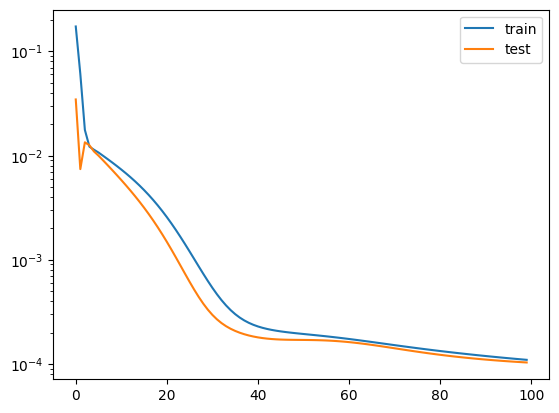

In [12]:
...
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yscale('log')
plt.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

27/27 [==============================] - 1s 3ms/step
Test RMSE: 0.073


In [14]:
# Save the Model
model.save('/content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/Temperature Control Project/LSTM_room_temp\assets


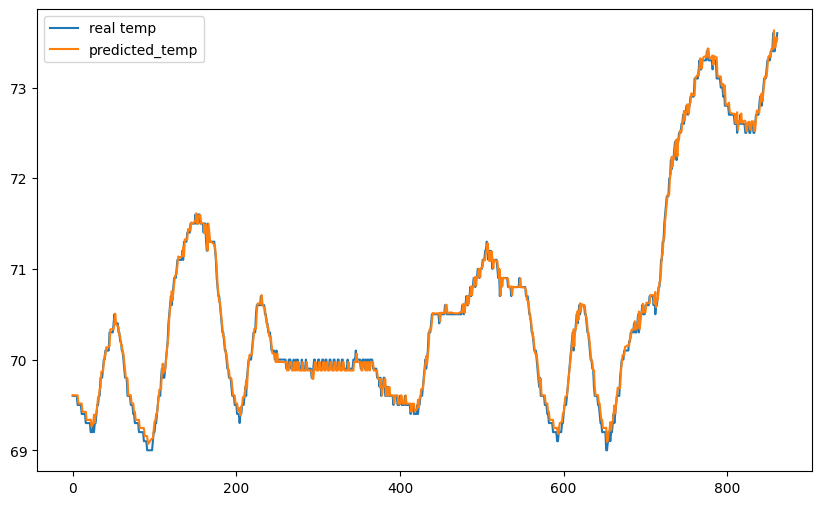

In [15]:
t = np.arange(0, len(inv_y))
plt.figure(figsize=(10, 6))
plt.plot(t, inv_y)
plt.plot(t, inv_yhat)
plt.legend(['real temp', 'predicted_temp'])
plt.show()

## Section 3.2: Pytorch

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [14]:
# load dataset
dataset = pd.read_csv('data-B90102-30m.csv', header=0, index_col=0)
del dataset['htg_setpoint']
del dataset['htg_mode']
values = dataset.values
print(dataset.head())

                       room_temp  supply_temp  airflow_current
time                                                          
2021-04-26T09:37:00.0       72.3         59.3              416
2021-04-26T09:38:00.0       72.2         58.8              413
2021-04-26T09:39:00.0       72.2         58.5              419
2021-04-26T09:40:00.0       72.1         58.2              410
2021-04-26T09:41:00.0       71.9         58.1              404


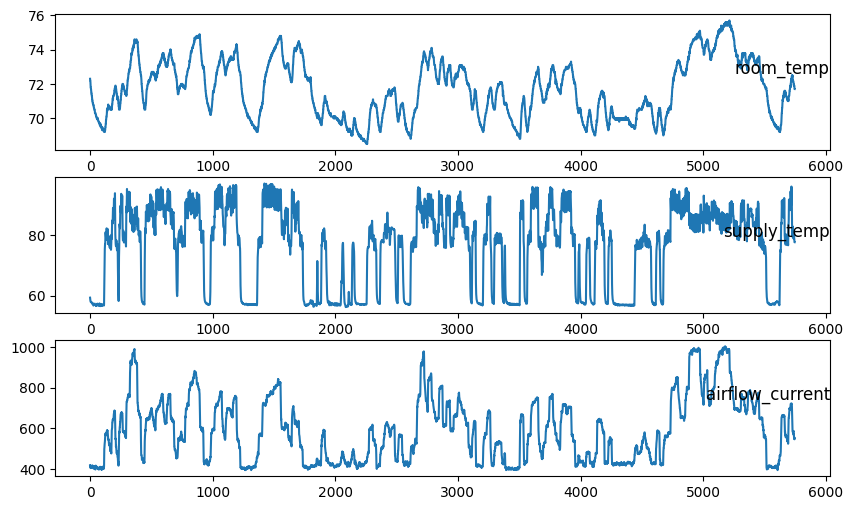

In [15]:
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure(figsize=(10, 6))
for group in groups:
 plt.subplot(len(groups), 1, i)
 plt.plot(values[:, group])
 plt.title(dataset.columns[group], y=0.5, loc='right')
 i += 1
plt.show()

In [16]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [17]:
# load dataset
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(values)
print('maximum value :' + str(scaler.data_max_))
print('minimum value :' + str(scaler.data_min_))
scaled = scaler.transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4, 5]], axis=1, inplace=True)
print(reframed.head())

maximum value :[  75.7   97.  1003. ]
minimum value :[ 68.5  56.2 394. ]
   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)
1   0.527779   0.075980   0.036125  0.513889
2   0.513889   0.063725   0.031199  0.513889
3   0.513889   0.056373   0.041051  0.500000
4   0.500000   0.049020   0.026273  0.472223
5   0.472223   0.046569   0.016420  0.458334


In [38]:
...
# split into train and test sets
values = reframed.values
train = values[0:train_nu]
test = values[train_nu:train_nu + test_nu]
validation= values[train_nu + test_nu: ]
# split into input and outputs
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [39]:
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 

Training Shape (4022, 3) (4022, 1)
Testing Shape (862, 3) (862, 1)


In [40]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [14]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

In [15]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4022, 1, 3]) torch.Size([4022, 1])
Testing Shape torch.Size([862, 1, 3]) torch.Size([862, 1])


In [231]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [237]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [238]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class

In [239]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)

In [240]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.09521
Epoch: 100, loss: 0.04610
Epoch: 200, loss: 0.04301
Epoch: 300, loss: 0.01246
Epoch: 400, loss: 0.00376
Epoch: 500, loss: 0.00206
Epoch: 600, loss: 0.00127
Epoch: 700, loss: 0.00085
Epoch: 800, loss: 0.00065
Epoch: 900, loss: 0.00050


In [241]:

X_test_tensor = Variable(torch.Tensor(X_test)) #converting to Tensors
#reshaping the dataset
X_test_tensor = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1]))
train_predict = lstm1(X_test_tensor)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion

inv_data_predict = np.concatenate((data_predict, X_test[:, 1:]), axis=1)
inv_data_predict = scaler.inverse_transform(inv_data_predict)
inv_data_predict = inv_data_predict[:,0]

inv_data = np.concatenate((test_y, X_test[:, 1:]), axis=1)
inv_data = scaler.inverse_transform(inv_data)
inv_data = inv_data[:,0]

rmse = sqrt(mean_squared_error(inv_data, inv_data_predict))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.115


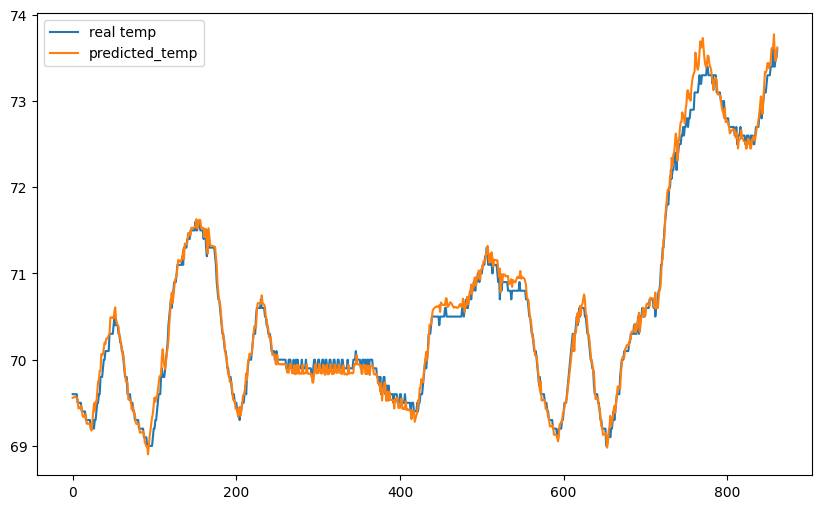

In [242]:
t = np.arange(0, len(inv_y))
plt.figure(figsize=(10, 6))
plt.plot(t, inv_data)
plt.plot(t, inv_data_predict)
plt.legend(['real temp', 'predicted_temp'])
plt.show()

In [243]:
torch.save(lstm1.state_dict(), "Pytorch_LSTM.pth")

# Section 4: MPC

- Model Predictive Control by Steve Brunton : https://www.youtube.com/watch?v=YwodGM2eoy4

- John Hedengren site: https://apmonitor.com/do/index.php/Main/TCLabG
- https://www.youtube.com/playlist?list=PLn8PRpmsu08ozoeoXgxPSBKLyd4YEHww8
- https://dynamics-and-control.readthedocs.io/en/latest/2_Control/7_Multivariable_control/Simple%20MPC.html
- https://github.com/gasagna/mpc
- https://yalmip.github.io/example/standardmpc/
- https://www.itk.ntnu.no/fag/TTK4135/Pensum/MPCkompendium%20HOvd.pdf
- https://www.youtube.com/watch?v=DFqOf5wbQtc

Important paper: Recurrent Neural Network-Based Model Predictive Control for Continuous Pharmaceutical Manufacturing https://www.mdpi.com/2227-7390/6/11/242/htm

- https://stackoverflow.com/questions/65720961/neural-network-mpc
- https://www.youtube.com/watch?v=uqivOJVbUNY
- https://www.youtube.com/watch?v=RrnkPrcpyEA

$Objective\:function = ||yt - y|| + c * \sum(a(T_s - 55) + b(\dot{m}_s-400) $

$ Subject\:to: 55<T_s<90,\: 400<\dot{m}_s<1000\:(Soft\:constraints)
$  

$ Subject\:to:|\Delta{T_s}|<8,\: |\Delta{\dot{m}_s}|<65\:(Hard\:constraints)$

Load required libraries

In [19]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from casadi import *

## 4.1: Casadi + Equation 

      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  42.00us (  2.00us)        21
       nlp_g  |        0 (       0)  39.00us (  1.86us)        21
    nlp_grad  |        0 (       0)   6.00us (  6.00us)         1
  nlp_grad_f  |   1.00ms ( 50.00us)  52.00us (  2.60us)        20
   nlp_jac_g  |        0 (       0)  22.00us (  1.10us)        20
       total  |  35.00ms ( 35.00ms)  35.46ms ( 35.46ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  48.00us (  1.66us)        29
       nlp_g  |        0 (       0)  51.00us (  1.76us)        29
    nlp_grad  |        0 (       0)   4.00us (  4.00us)         1
  nlp_grad_f  |        0 (       0)  61.00us (  2.18us)        28
   nlp_jac_g  |        0 (       0)  31.00us (  1.11us)        28
       total  |  69.00ms ( 69.00ms)  68.60ms ( 68.60ms)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

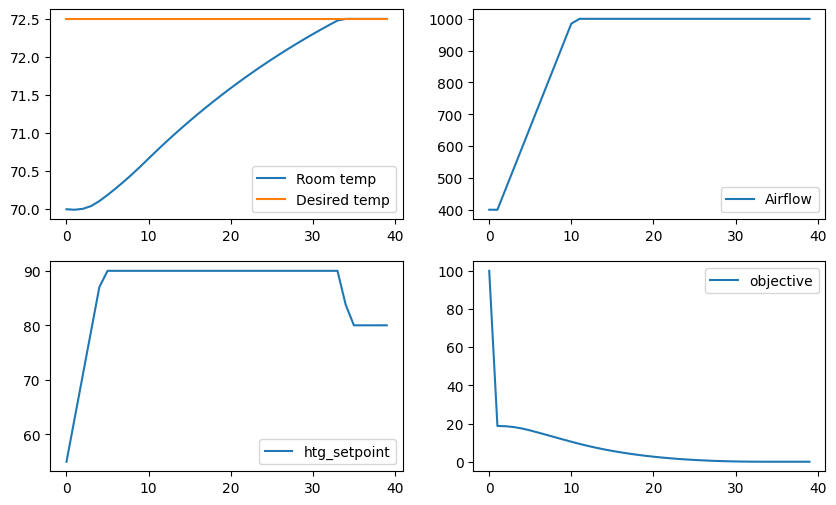

In [61]:
from casadi import *
import numpy as NP
import matplotlib.pyplot as plt
import time
from casadi.tools import *
from scipy import linalg, matrix
plt.interactive(True)

NP.random.seed(0)
N = 3 # Horizon length
runtime = 40
dt = 1; # Time step

# Equation patameters derived from parameters estimation
k_ep = 62.62
Ta_ep = 70.30
ca_ep = 0.017
d_ep = 10.0
C_ep = 3001.24

#states
states = struct_symSX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symSX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


rhs = struct_SX(states)
rhs["T"] = (k_ep * (Ta_ep - T) + Ms * ca_ep * (Ts - T) + d_ep) / C_ep

f = Function('f', [states,controls],[rhs])

# Build an integrator for this system: Runge Kutta 4 integrator
k1 = f(states,controls)
k2 = f(states+dt/2.0*k1,controls)
k3 = f(states+dt/2.0*k2,controls)
k4 = f(states+dt*k3,controls)
states_1 = states+dt/6.0*(k1+2*k2+2*k3+k4)
phi = Function('phi', [states,controls],[states_1])


# Create tructure for the entire horizon
variables = struct_symSX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symSX([entry("x0", shape=(6, 1))])

# NPL for optimization
obj = 0
a = 1
b =0.000001
sigma = 0.00001

obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = phi(parameters["x0", 0], variables["U", 0])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = phi(parameters["x0", 0], variables["U", k])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)


#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0

max_delta_Ms = 65.0
min_delta_Ms = -65.0

# Soft constraints
max_Ts = 90.0
min_Ts = 55.0

max_Ms = 1000.0
min_Ms = 400.0

min_Ts_global = 55.0
min_Ms_global = 400.0

args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb

# Lets run our simulation 
x0 = 70.0
xs = 72.5


t = np.arange(0, runtime, dt)
xxs = np.full((runtime,1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(100)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

u0 = []
for i in range(N):
  u0 += [55]
  u0 += [400]


# simulate
args['x0'] = u0

for i in range(1,runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])

  # con_base = vertcat(min_Ts, min_Ms)
  st_next = phi(args['p'][0], sol['x'][0:2])

  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])

plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx)
plt.plot(t, xxs)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()




## 4.2 CasADi + LSTM (Keras)

### Slow  version

In [82]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time


In [83]:
LSTM_model = keras.models.load_model("LSTM_room_temp")

In [76]:
# Callback function for evaluating LSTM

class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    input = np.array([arg[0], arg[1], arg[2]]).astype('float32').reshape(1,-1)
    input_reframed = input.reshape((input.shape[0], 1, input.shape[1]))
    f = LSTM_model(input_reframed)
    return [f.numpy()[0, 0]]

In [79]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [81]:
lstm = MyCallback('lstm', {"enable_fd":True})

T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

initializing object


DM(70.162)

In [84]:
runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.000001
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])


      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   9.84 s ( 17.36ms)   9.83 s ( 17.34ms)       567
       nlp_g  |   3.00ms (  5.29us)   3.70ms (  6.53us)       567
    nlp_grad  | 460.00ms (460.00ms) 460.64ms (460.64ms)         1
  nlp_grad_f  |  12.30 s (241.10ms)  12.30 s (241.14ms)        51
   nlp_jac_g  |        0 (       0) 664.00us ( 13.02us)        51
       total  |  22.88 s ( 22.88 s)  22.88 s ( 22.88 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  17.53 s ( 17.12ms)  17.51 s ( 17.10ms)      1024
       nlp_g  |   9.00ms (  8.79us)   6.58ms (  6.42us)      1024
    nlp_grad  | 454.00ms (454.00ms) 453.89ms (453.89ms)         1
  nlp_grad_f  |  24.40 s (239.17ms)  24.40 s (239.19ms)       102
   nlp_jac_g  |   1.00ms (  9.80us)   1.38ms ( 13.56us)       102
       total  |  42.93 s ( 42.93 s)  42.93 s ( 42.93 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [86]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

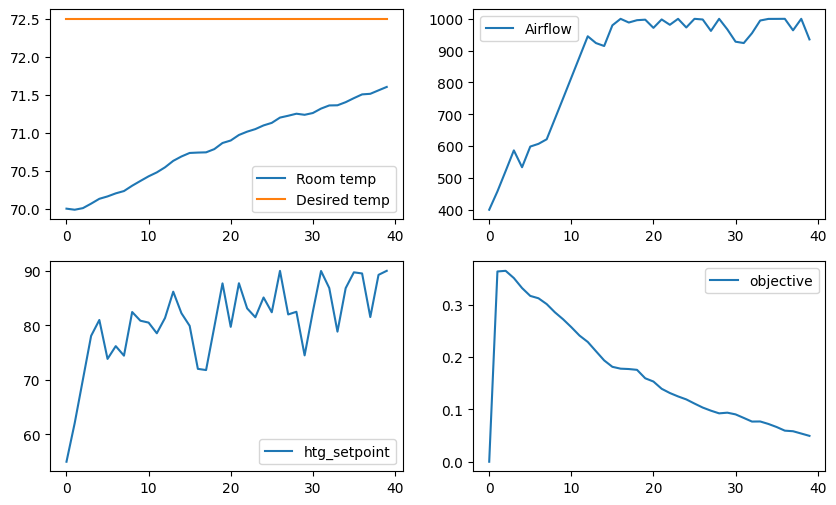

In [87]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()

### Fast Version
- https://www.activestate.com/resources/quick-reads/how-to-create-a-neural-network-in-python-with-and-without-keras/
- https://web.casadi.org/blog/tensorflow/
- Introduction of CasADi https://www.youtube.com/watch?v=JC6PNjndQ_c&t=61s


## 4.3 CasADi + LSTM (PyTorch)

-https://arxiv.org/pdf/2203.07747.pdf

In [88]:
from casadi import *
from casadi.tools import *
from scipy import linalg, matrix
import pandas as pd

import matplotlib.pyplot as plt
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable 

import numpy as np
import time


In [89]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [90]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = 3 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [91]:

loaded_lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, input_size)
loaded_lstm.load_state_dict(torch.load("Pytorch_LSTM.pth"))
loaded_lstm.eval()

LSTM1(
  (lstm): LSTM(3, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [92]:
class MyCallback(Callback):
  def __init__(self, name, opts={}):
    Callback.__init__(self)
    self.construct(name, opts)

  # Number of inputs and outputs
  def get_n_in(self): return 3
  def get_n_out(self): return 1

  # Initialize the object
  def init(self):
     print('initializing object')

  # Evaluate numerically
  def eval(self, arg):
    T = arg[0]
    Ts = arg[1]
    Ms = arg[2]
    input = np.array([T, Ts, Ms]).astype('float32').reshape(1,-1)
    input_tensor = Variable(torch.Tensor(input)) 
    input_tensor = torch.reshape(input_tensor, (input_tensor.shape[0], 1, input_tensor.shape[1]))
    output = loaded_lstm(input_tensor)
    output = output.detach().numpy()
    return [output]

In [93]:
def normal(x, min, max):
    norm = (x - min)/(max - min)
    return norm

def revnormal(x, min, max):
    norm = (x * (max - min)) + min
    return norm

def normaldelta(x, min, max):
    norm = (x)/(max - min)
    return norm

In [94]:
lstm = MyCallback('lstm', {"enable_fd":True})
T = 70
Ts = 90
Ms = 1000
T = normal(T, scaler.data_min_[0],  scaler.data_max_[0])
Ts = normal(Ts, scaler.data_min_[1],  scaler.data_max_[1])
Ms = normal(Ms, scaler.data_min_[2],  scaler.data_max_[2])

To = revnormal(lstm(T, Ts, Ms), scaler.data_min_[0],  scaler.data_max_[0])
To

initializing object


DM(70.0667)

In [95]:

runtime = 40
N = 3 # Horizon length
dt = 1; # Time step
obj = 0
a = 1
b =0.000001
sigma = 0.00001
#---------------------->
# Hard constraint on inputs
max_delta_Ts = 8.0
min_delta_Ts = -8.0


max_delta_Ms = 65.0
min_delta_Ms = -65.0


# Soft constraints
max_Ts = 90.0
min_Ts = 55.0


max_Ms = 1000.0
min_Ms = 400.0


min_Ts_global = min_Ts
min_Ms_global = min_Ms

# Lets run our simulation ********
x0 = 70.0
xs = 72.5


#Normalize our data
max_delta_Ts = normaldelta(max_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_delta_Ts = normaldelta(min_delta_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_delta_Ms = normaldelta(max_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_delta_Ms = normaldelta(min_delta_Ms, scaler.data_min_[2],  scaler.data_max_[2])


max_Ts = normal(max_Ts, scaler.data_min_[1],  scaler.data_max_[1])
min_Ts = normal(min_Ts, scaler.data_min_[1],  scaler.data_max_[1])

max_Ms = normal(max_Ms, scaler.data_min_[2],  scaler.data_max_[2])
min_Ms = normal(min_Ms, scaler.data_min_[2],  scaler.data_max_[2])

min_Ts_global = min_Ts
min_Ms_global = min_Ms

x0 = normal(x0, scaler.data_min_[0],  scaler.data_max_[0])
xs = normal(xs, scaler.data_min_[0],  scaler.data_max_[0])

#states
states = struct_symMX(["T"])
n_states = states.size
T, = states[...]

#controls
controls = struct_symMX(["Ts", "Ms"])
n_controls = controls.size
Ts, Ms = controls[...]


# Create tructure for the entire horizon
variables = struct_symMX([(entry("U",repeat=N ,struct=controls))])
parameters = struct_symMX([entry("x0", shape=(6, 1))])

# NPL for optimization


obj += (parameters["x0", 0] - parameters["x0", 1])**2 + sigma*(a*(
    variables["U", 0][0] - parameters["x0", 4]) + b * (
        variables["U", 0][1] - parameters["x0", 5])**2)

st = lstm(parameters["x0", 0], variables["U", 0][0], variables["U", 0][1])

for k in range(1, N):
  # Computing the objective function
  obj += (st - parameters["x0", 1])**2 + sigma*(a*(
      variables["U", k][0] - parameters["x0", 4]) + b * (
          variables["U", k][1] - parameters["x0", 5])**2)
  
  
  st_next = lstm(parameters["x0", 0], variables["U", k][0], variables["U", k][1])
  st = st_next 

# Build the single shooting constraints          
g = []
g.append(variables["U", 0][0])
g.append(variables["U", 0][1])
g.append(variables["U", 0][0] - parameters["x0", 2])
g.append(variables["U", 0][1] - parameters["x0", 3])

for k in range(1, N):
  # Constraints
  g.append(variables["U", k][0])
  g.append(variables["U", k][1])
  g.append(variables["U", k][0] - variables["U", k-1][0])
  g.append(variables["U", k][1] - variables["U", k-1][1])

# Formulate the NLP
nlp = {'x':variables, 'p':parameters, 'f':obj, 'g':vertcat(*g)}
# Create the solver
opts = {"ipopt.print_level":0, "print_time": True, 'ipopt.max_iter':100,
        "ipopt.hessian_approximation": "limited-memory"}
nlpsol = nlpsol("nlpsol", "ipopt", nlp, opts)




args = {}

upperb = []
lowerb = []

for i in range(N):
  upperb.append(max_Ts)
  upperb.append(max_Ms)
  upperb.append(max_delta_Ts)
  upperb.append(max_delta_Ms)

  lowerb.append(min_Ts)
  lowerb.append(min_Ms)
  lowerb.append(min_delta_Ts)
  lowerb.append(min_delta_Ms)


args['lbg'] = lowerb
args['ubg'] = upperb


t = np.arange(0, runtime, dt)
xxs = np.full((runtime, 1), xs)
xx = []
xx.append(x0)

cost = []
cost.append(0)

TTs = []
TTs.append(min_Ts)

MMs = []
MMs.append(min_Ms)

# initial geuss for the optimization variables
mpxiter = 0

#************** 
u0 = []
for i in range(N):
  u0 += [min_Ts]
  u0 += [min_Ms]


# simulate
args['x0'] = u0

for i in range(1, runtime):

  args['p'] = horzcat(x0, xs, min_Ts, min_Ms, min_Ts_global, min_Ms_global)
  sol = nlpsol(x0=args['x0'], ubg=args['ubg'], lbg=args['lbg'],
              p=args['p'])


  st_next = lstm(args['p'][0], sol['x'][0], sol['x'][1])
  x0 = st_next
  min_Ts =  sol['x'][0]
  min_Ms =  sol['x'][1]
  
  xx.append(np.array(st_next)[0][0])
  cost.append(np.array(sol['f'])[0][0])
  TTs.append(np.array(sol['x'][0])[0][0])
  MMs.append(np.array(sol['x'][1])[0][0])



      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.02 s (  1.65ms)   2.04 s (  1.67ms)      1225
       nlp_g  |  11.00ms (  8.98us)   7.86ms (  6.42us)      1225
    nlp_grad  |  48.00ms ( 48.00ms)  48.19ms ( 48.19ms)         1
  nlp_grad_f  |   2.33 s ( 22.86ms)   2.34 s ( 22.90ms)       102
   nlp_jac_g  |   3.00ms ( 29.41us)   1.51ms ( 14.82us)       102
       total  |   5.09 s (  5.09 s)   5.09 s (  5.09 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.04 s (  1.56ms)   2.05 s (  1.56ms)      1313
       nlp_g  |   6.00ms (  4.57us)   6.58ms (  5.01us)      1313
    nlp_grad  |  35.00ms ( 35.00ms)  35.32ms ( 35.32ms)         1
  nlp_grad_f  |   2.24 s ( 21.97ms)   2.24 s ( 21.98ms)       102
   nlp_jac_g  |        0 (       0)   1.40ms ( 13.74us)       102
       total  |   5.05 s (  5.05 s)   5.05 s (  5.05 s)         1
      nlpsol  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp

In [96]:
# Reverse the normalization
xx_rev = revnormal(np.array(xx), scaler.data_min_[0],  scaler.data_max_[0])
xxs_rev = revnormal(np.array(xxs), scaler.data_min_[0],  scaler.data_max_[0])
TTs_rev = revnormal(np.array(TTs), scaler.data_min_[1],  scaler.data_max_[1])
MMs_rev = revnormal(np.array(MMs), scaler.data_min_[2],  scaler.data_max_[2])

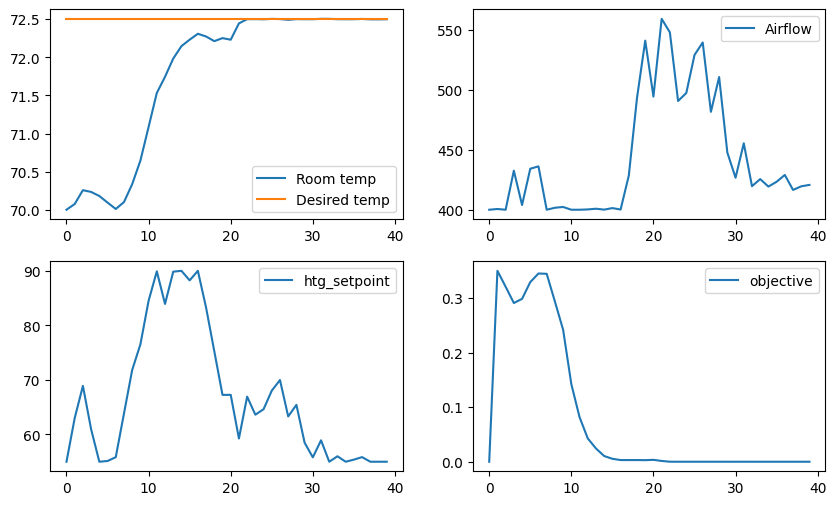

In [97]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.plot(t, xx_rev)
plt.plot(t, xxs_rev)
plt.legend(['Room temp', 'Desired temp'])

plt.subplot(2, 2, 2)
plt.plot(t, MMs_rev)
plt.legend(['Airflow'])


plt.subplot(2, 2, 3)
plt.plot(t, TTs_rev)
plt.legend(['htg_setpoint'])

plt.subplot(2, 2, 4)
plt.plot(t, cost)
plt.legend(['objective'])

plt.show()